# Slides 12 — Images that maximally activate a neuron

This notebook scans an **ImageFolder** dataset and returns a **grid** of images that maximally activate a chosen **layer/channel**, showing **mono‑ vs. polysemantic** behavior.

Matches **pages 12–13** in your deck (Szegedy et al. 2014 examples).

**Inputs needed:** set `DATA_ROOT` to your `ImageFolder` (e.g., ImageNet `val/`, Imagenette, or any folder-of-folders).


In [1]:
import sys, os
from pathlib import Path

def add_src_to_path():
    here = Path.cwd()
    for p in [here, *here.parents]:
        cand = p / "src"
        if cand.exists():
            sys.path.insert(0, str(cand))
            print("Added to sys.path:", cand)
            return cand
    raise FileNotFoundError("Couldn't find a 'src' folder above this notebook.")
_ = add_src_to_path()


Added to sys.path: /Users/juliawenkmann/Documents/CodingProjects/damien/sophia_summit/sophia_summit_presentation/src


In [2]:
# --- Parameters ---
DATA_ROOT = "/Users/juliawenkmann/Documents/CodingProjects/tcav_projects/tcav_variability/src/tcavlab/datasets/TCAV_Images/random"  # <- CHANGE THIS
MODEL = "googlenet"                                  # "googlenet" | "resnet50" | "inception_v3"
LAYER_PATH = "inception4a.branch1.conv"              # consistent with GoogLeNet examples
CHANNEL = 11
TOPK = 16
BATCH_SIZE = 32
INPUT_SIZE = 224
OUT_PATH = "assets/outputs/slides12_13_grid.png"


In [3]:
# --- Download & prepare a tiny, class-structured dataset (Imagenette-320) ---
# Plug-n-play: run this cell once, then set DATA_ROOT = DATA_DIR / "val" below.

import os, sys, tarfile, hashlib, shutil, urllib.request
from pathlib import Path
from collections import Counter

# Where to put data (relative to your notebook/repo)
DATA_DIR = Path("assets/data/imagenette2-320")
ARCHIVE  = DATA_DIR.parent / "imagenette2-320.tgz"
URL      = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz"
# Known size ~ 346 MB; no official checksum published here, but we can re-download if extract fails.

def _download(url: str, dest: Path, chunk=1<<20):
    dest.parent.mkdir(parents=True, exist_ok=True)
    if dest.exists() and dest.stat().st_size > 10_000_000:
        print(f"✔ Archive already present: {dest} ({dest.stat().st_size/1e6:.1f} MB)")
        return
    print(f"↓ Downloading {url} → {dest} …")
    with urllib.request.urlopen(url) as r, open(dest, "wb") as f:
        total = int(r.headers.get("Content-Length", 0))
        done = 0
        while True:
            b = r.read(chunk)
            if not b: break
            f.write(b); done += len(b)
            if total:
                pct = 100.0 * done / total
                print(f"\r  {done/1e6:.1f}/{total/1e6:.1f} MB ({pct:5.1f}%)", end="")
    print("\n✔ Download complete.")

def _extract(archive: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    # The tgz contains a root folder "imagenette2-320/" with train/ and val/
    print(f"↗ Extracting {archive} …")
    with tarfile.open(archive, "r:gz") as tf:
        tf.extractall(path=out_dir.parent)
    # Move into DATA_DIR if needed (ensure path consistency)
    root = out_dir.parent / "imagenette2-320"
    if root.exists() and root != out_dir:
        if out_dir.exists():
            shutil.rmtree(out_dir)
        root.rename(out_dir)
    print(f"✔ Extracted to: {out_dir.resolve()}")

def _verify_class_structure(split_dir: Path):
    if not split_dir.exists():
        return False, "Missing split dir"
    subdirs = [p for p in split_dir.iterdir() if p.is_dir()]
    if not subdirs:
        return False, "No class subfolders found"
    num_imgs = sum(len([f for f in c.rglob("*") if f.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp",".tiff"}]) for c in subdirs)
    return True, f"{len(subdirs)} classes, {num_imgs} images"

# 1) Download (if needed)
_download(URL, ARCHIVE)

# 2) Extract (idempotent)
if not (DATA_DIR / "val").exists():
    _extract(ARCHIVE, DATA_DIR)

# 3) Verify structure
ok, msg = _verify_class_structure(DATA_DIR / "val")
print("VAL split:", "OK -" if ok else "ERR -", msg)
if not ok:
    # Retry extraction if something went wrong
    _extract(ARCHIVE, DATA_DIR)
    ok, msg = _verify_class_structure(DATA_DIR / "val")
    print("VAL split (after retry):", "OK -" if ok else "ERR -", msg)

# 4) Optional: limit per-class count to speed up scans (comment out if you want full set)
def limit_per_class(split_dir: Path, max_per_class=120):
    if max_per_class is None:
        return
    import random
    random.seed(0)
    for cls in [p for p in split_dir.iterdir() if p.is_dir()]:
        imgs = [f for f in cls.glob("*") if f.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp",".tiff"}]
        if len(imgs) > max_per_class:
            keep = set(random.sample(imgs, max_per_class))
            for f in imgs:
                if f not in keep:
                    f.unlink()
    print(f"✔ Limited to ≤{max_per_class} images per class in {split_dir}")

# Uncomment to speed up development runs
# limit_per_class(DATA_DIR / "val", max_per_class=120)

# 5) Set DATA_ROOT for your existing notebook code:
DATA_ROOT = str((DATA_DIR / "val").resolve())
print("DATA_ROOT set to:", DATA_ROOT)

# 6) (Optional) Quick peek at class counts
from collections import defaultdict
counts = defaultdict(int)
for cls_dir in Path(DATA_ROOT).iterdir():
    if cls_dir.is_dir():
        counts[cls_dir.name] = len([f for f in cls_dir.glob("*") if f.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp",".tiff"}])
print("Class counts:", dict(counts))


↓ Downloading https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz → assets/data/imagenette2-320.tgz …
  341.7/341.7 MB (100.0%)
✔ Download complete.
↗ Extracting assets/data/imagenette2-320.tgz …


/var/folders/k7/xf0yhfbs02ggfm7n1l5g_cnm0000gn/T/ipykernel_65742/1967664562.py:37: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall(path=out_dir.parent)


✔ Extracted to: /Users/juliawenkmann/Documents/CodingProjects/damien/sophia_summit/sophia_summit_presentation/notebooks/assets/data/imagenette2-320
VAL split: OK - 10 classes, 3925 images
DATA_ROOT set to: /Users/juliawenkmann/Documents/CodingProjects/damien/sophia_summit/sophia_summit_presentation/notebooks/assets/data/imagenette2-320/val
Class counts: {'n03394916': 394, 'n03417042': 389, 'n03445777': 399, 'n02102040': 395, 'n03425413': 419, 'n03888257': 390, 'n03028079': 409, 'n03000684': 386, 'n01440764': 387, 'n02979186': 357}


In [4]:
from activations import load_model, find_topk_images_for_unit, save_image_grid
import os
assert os.path.exists(DATA_ROOT), f"DATA_ROOT does not exist: {DATA_ROOT}"
model = load_model(MODEL, pretrained=True)
topk = find_topk_images_for_unit(model, LAYER_PATH, DATA_ROOT, k=TOPK, channel=CHANNEL, batch_size=BATCH_SIZE, model_input_size=INPUT_SIZE)
print(f"Top {TOPK} scores (first 5 shown):")
for t in topk[:5]:
    print(f"{t.score:.4f}  {t.path}")
paths = [t.path for t in topk]
save_image_grid(paths, OUT_PATH)
OUT_PATH

/Users/juliawenkmann/Documents/CodingProjects/damien/sophia_summit/sophia_summit_presentation/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Top 16 scores (first 5 shown):
7.2822  /Users/juliawenkmann/Documents/CodingProjects/damien/sophia_summit/sophia_summit_presentation/notebooks/assets/data/imagenette2-320/val/n03425413/n03425413_20371.JPEG
7.2142  /Users/juliawenkmann/Documents/CodingProjects/damien/sophia_summit/sophia_summit_presentation/notebooks/assets/data/imagenette2-320/val/n03028079/n03028079_26272.JPEG
7.1318  /Users/juliawenkmann/Documents/CodingProjects/damien/sophia_summit/sophia_summit_presentation/notebooks/assets/data/imagenette2-320/val/n03888257/n03888257_10341.JPEG
7.0283  /Users/juliawenkmann/Documents/CodingProjects/damien/sophia_summit/sophia_summit_presentation/notebooks/assets/data/imagenette2-320/val/n03888257/n03888257_34081.JPEG
6.9933  /Users/juliawenkmann/Documents/CodingProjects/damien/sophia_summit/sophia_summit_presentation/notebooks/assets/data/imagenette2-320/val/n03028079/n03028079_1870.JPEG


'assets/outputs/slides12_13_grid.png'

### Display the grid


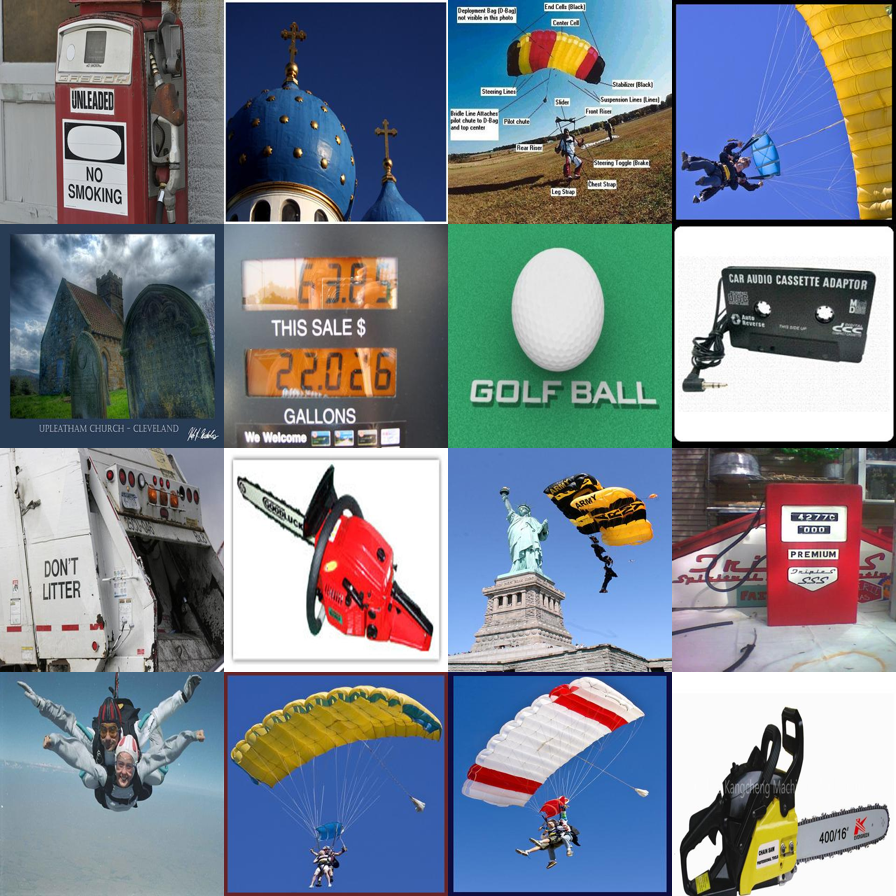

In [5]:
from PIL import Image
display(Image.open(OUT_PATH))


> Try changing `CHANNEL` or `LAYER_PATH` (use **00_layer_browser** to find dot‑paths) and regenerate the grid to compare mono vs. polysemantic behavior.
